In [1]:

# LSTM model dummy
# Dummy model to predict the climate time series data

# !nvidia-smi

import tensorflow as tf 
# !pip install tensorflow-gpu
print(tf.__version__)

print('1: ', tf.config.list_physical_devices('GPU'))


2.6.2
1:  []


In [92]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# import tabloo
from tensorflow import keras
# from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout, Bidirectional, RepeatVector, TimeDistributed
import math
from sklearn.metrics import mean_squared_error
from ipywidgets import interactive
%matplotlib inline

## Data Processing

### Data Fetching and Cleaning

In [3]:
#getting data and sorting it into all the present IDs

scaler = MinMaxScaler()
df_normal = pd.read_csv('train_1.csv', delimiter=',')
df_normal = df_normal.dropna(axis=1, how='all')
df_normal[['Time']] = scaler.fit_transform(df_normal[['Time']])

# all_IDs = np.array(df_normal.groupby(['ID']).count().index.values)
# print((np.sort(all_IDs)))
all_IDs = np.array(['id1','id5'])
print(all_IDs)
df_ID_list = list()
for i in all_IDs:
    temp = df_normal[df_normal['ID']==i].dropna(axis=1, how='all')
    temp = temp.drop(temp[['Label']],axis =1)
    temp = temp.drop(temp[['ID']],axis =1)
    temp = temp.iloc[0:1000000,0:2]
    df_ID_list.append(temp)

for i in range(len(df_ID_list)):
    # tabloo.show(i)
    print(len(df_ID_list[i]))
    print(df_ID_list[i])

['id1' 'id5']
1000000
                 Time   Signal1
5        7.768963e-07  0.000000
12       1.743012e-06  0.000000
20       2.709128e-06  0.000000
27       3.675243e-06  0.000000
33       4.641359e-06  0.000000
...               ...       ...
7166892  9.662234e-01  0.797424
7166902  9.662244e-01  0.797524
7166907  9.662253e-01  0.797604
7166915  9.662263e-01  0.797704
7166922  9.662273e-01  0.797794

[1000000 rows x 2 columns]
1000000
                 Time   Signal1
0        0.000000e+00  0.000000
6        9.661157e-07  0.000000
13       1.932231e-06  0.000000
21       2.898347e-06  0.000000
28       3.864463e-06  0.000000
...               ...       ...
7166897  9.662238e-01  0.226013
7166905  9.662248e-01  0.225260
7166912  9.662257e-01  0.224512
7166918  9.662267e-01  0.223505
7166927  9.662276e-01  0.222048

[1000000 rows x 2 columns]


In [4]:
df_ID_list[1]['Signal1']

0          0.000000
6          0.000000
13         0.000000
21         0.000000
28         0.000000
             ...   
7166897    0.226013
7166905    0.225260
7166912    0.224512
7166918    0.223505
7166927    0.222048
Name: Signal1, Length: 1000000, dtype: float64

['id1' 'id5']
250000
         Label          Time  Signal1_of_ID
1            0  5.674957e-08       0.165060
7            0  3.389731e-06       0.165400
16           0  6.722713e-06       0.165821
22           0  1.005570e-05       0.166301
29           0  1.338868e-05       0.166662
...        ...           ...            ...
1791696      0  8.333274e-01       0.409938
1791705      0  8.333307e-01       0.409137
1791711      0  8.333341e-01       0.408346
1791718      0  8.333374e-01       0.407586
1791726      0  8.333407e-01       0.406815

[250000 rows x 3 columns]
250000
         Label      Time  Signal1_of_ID
4            0  0.000001       0.037628
12           0  0.000005       0.037723
19           0  0.000008       0.037833
27           0  0.000011       0.037915
32           0  0.000015       0.037969
...        ...       ...            ...
1791700      0  0.833328       0.093077
1791708      0  0.833332       0.092897
1791713      0  0.833335       0.092724
1791723      0  0

Text(0.5, 1.0, 'Plateau Attack (180000-190000) values')

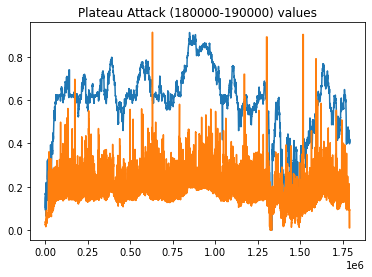

In [5]:
df_test_plat_ID1 = pd.read_csv('test_plateau.csv', delimiter=',')
df_test_plat_ID1 = df_test_plat_ID1.dropna(axis=1, how='all')
# df_test_plat_ID1 = df_test_plat_ID1.iloc[0:(int(len(df_test_plat_ID1)/5)),:]
# df_test_plat_ID1 = df_test_plat_ID1.iloc[180000:400000,:]
df_test_plat_ID1[['Time']] = scaler.fit_transform(df_test_plat_ID1[['Time']])

# df_test_plat_ID1.iloc[180000:250000,0:2]

all__test_IDs = np.array(['id1','id5'])
print(all_IDs)
df_testID_list = list()

for i in all__test_IDs:
    tempTest = df_test_plat_ID1[df_test_plat_ID1['ID']==i].dropna(axis=1, how='all')
    # tempTest = tempTest.drop(tempTest[['Label']],axis =1)
    tempTest = tempTest.drop(tempTest[['ID']],axis =1)
    tempTest = tempTest.iloc[0:250000,0:3]
    df_testID_list.append(tempTest)

for i in range(len(df_testID_list)):
    # tabloo.show(i)
    print(len(df_testID_list[i]))
    print(df_testID_list[i])


plt.plot(df_testID_list[0].iloc[:,2:3])
plt.plot(df_testID_list[1].iloc[:,2:3])
plt.title('Plateau Attack (180000-190000) values')

In [6]:


# create a test dataset of 30 sequences from the provided Data
def createTestDataset(x,y,time_step):
    Xs,Ys = [],[]
    for j in range(len(x)):
        v = []
        p = []
        for i in range(len(x[j])-time_step):
            y = x[j]['Signal1_of_ID'].iloc[i:i+time_step].values
            v.append(y)
            p.append(x[j]['Signal1_of_ID'].iloc[i+time_step])
        Xs.append(v)
        Ys.append(p)
    
    # print(Xs)
    # print(Ys)
            
    return np.array(Xs),np.array(Ys)
    

In [7]:


# create a dataset of 30 sequences from the provided Data
def creatDataset(x,y,time_step):
    Xs,Ys = [],[]
    for j in range(len(x)):
        v = []
        p = []
        for i in range(len(x[j])-time_step):
            y = x[j]['Signal1'].iloc[i:i+time_step].values
            v.append(y)
            p.append(x[j]['Signal1'].iloc[i+time_step])
        Xs.append(v)
        Ys.append(p)
    
    # print(Xs)
    # print(Ys)
            
    return np.array(Xs),np.array(Ys)
    

In [8]:
TIME_STEP = 30
X_train, Y_train = creatDataset(df_ID_list, df_ID_list, TIME_STEP)
X_test, Y_test = createTestDataset(df_testID_list, df_testID_list, TIME_STEP)

# X_train.shape

# X_test.shape

In [9]:
print(X_train.shape)
print(Y_train.shape)

(2, 999970, 30)
(2, 999970)


In [10]:
print(X_test.shape)
print(Y_test.shape)

(2, 249970, 30)
(2, 249970)


In [11]:
a = np.reshape(X_train,(-1,2,30,1))
b = np.reshape(Y_train,(-1,2,1))

print(a.shape)
print(b.shape)

(999970, 2, 30, 1)
(999970, 2, 1)


In [12]:
p = np.reshape(X_test,(-1,2,30,1))
q = np.reshape(Y_test,(-1,2,1))
print(p.shape)
print(q.shape)

(249970, 2, 30, 1)
(249970, 2, 1)


In [13]:
print(a.shape)
print(a)

(999970, 2, 30, 1)
[[[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]


 ...


 [[[0.21071127]
   [0.21224839]
   [0.21353995]
   ...
   [0.22860827]
   [0.22812398]
   [0.22744244]]

  [[0.21224839]
   [0.21353995]
   [0.21457229]
   ...
   [0.22812398]
   [0.22744244]
   [0.2267609 ]]]


 [[[0.21353995]
   [0.21457229]
   [0.21503333]
   ...
   [0.22744244]
   [0.2267609 ]
   [0.22601284]]

  [[0.21457229]
   [0

In [14]:


# n_features = X_train.shape[2]
model= Sequential()
model.add(
    TimeDistributed(
        LSTM(128, activation='relu', return_sequences = True), 
        input_shape=(2,30,1) #all IDs LSTMs 
    )
)

model.add(
    TimeDistributed(
        Flatten() 
    )
)
model.add(Dense(512, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(256, activation='relu'))

model.add(TimeDistributed(Dense(30)))
model.compile(optimizer='adam', loss='mean_absolute_error')

model.summary()
# plot_model(model, to_file='model_plot.png', 
#            show_shapes=True, show_layer_names=True,
#            show_layer_activations=False, expand_nested=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 2, 30, 128)        66560     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 2, 3840)           0         
_________________________________________________________________
dense (Dense)                (None, 2, 512)            1966592   
_________________________________________________________________
dense_1 (Dense)              (None, 2, 64)             32832     
_________________________________________________________________
dense_2 (Dense)              (None, 2, 256)            16640     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 2, 30)             7710      
Total params: 2,090,334
Trainable params: 2,090,334
Non-trainable params: 0
______________________________________________

#### Model Fitting

In [15]:
# fit model
model.fit(a, b, epochs=15, batch_size=30, validation_split=0.1, shuffle=False)
model.save("multi_ID_LSTM_autoenc")

Epoch 1/15
30000/30000 [==============================] - 450s 15ms/step - loss: 0.0123 - val_loss: 0.0276
Epoch 2/15
30000/30000 [==============================] - 455s 15ms/step - loss: 0.0129 - val_loss: 0.0107
Epoch 3/15
30000/30000 [==============================] - 456s 15ms/step - loss: 0.0130 - val_loss: 0.0046
Epoch 4/15
30000/30000 [==============================] - 452s 15ms/step - loss: 0.0135 - val_loss: 0.0061
Epoch 5/15
30000/30000 [==============================] - 448s 15ms/step - loss: 0.0125 - val_loss: 0.0072
Epoch 6/15
30000/30000 [==============================] - 447s 15ms/step - loss: 0.0129 - val_loss: 0.0136
Epoch 7/15
30000/30000 [==============================] - 447s 15ms/step - loss: 0.0101 - val_loss: 0.0080
Epoch 8/15
30000/30000 [==============================] - 447s 15ms/step - loss: 0.0090 - val_loss: 0.0053
Epoch 9/15
30000/30000 [==============================] - 447s 15ms/step - loss: 0.0076 - val_loss: 0.0034
Epoch 10/15
30000/30000 [============

#### Model Prediction

In [14]:
reconstructed_model = keras.models.load_model("multi_ID_LSTM_autoenc")

In [15]:
x_test_predict = reconstructed_model.predict(p, verbose=0)
x_train_predict = reconstructed_model.predict(a, verbose=0)

print(x_train_predict.shape)
print(x_test_predict.shape)

(999970, 2, 30)
(249970, 2, 30)


In [16]:
x_test_predict_X= x_test_predict[:,0]
print(x_test_predict[:,0])
print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
print(p[:,0])
print("\n------------------------------------------------------------------------------------------------------------------\n")
print(x_test_predict[:,1])
print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
print(p[:,1])

[[0.1744186  0.17287749 0.17394394 ... 0.17444223 0.17395994 0.17291564]
 [0.17389673 0.17235437 0.17342165 ... 0.17392117 0.17343804 0.17239252]
 [0.17353523 0.17199203 0.17305988 ... 0.17356023 0.17307657 0.17203018]
 ...
 [0.12409839 0.12243807 0.12358424 ... 0.12419978 0.12364045 0.12247574]
 [0.12057051 0.11890182 0.12005359 ... 0.12067732 0.12011263 0.11893946]
 [0.11557811 0.11389762 0.11505729 ... 0.11569268 0.11512032 0.1139352 ]]
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
[[[0.16505995]
  [0.16540026]
  [0.1658207 ]
  ...
  [0.168033  ]
  [0.16778276]
  [0.16760261]]

 [[0.1658207 ]
  [0.16630121]
  [0.16666157]
  ...
  [0.16760261]
  [0.16741244]
  [0.1672623 ]]

 [[0.16666157]
  [0.16690179]
  [0.16701191]
  ...
  [0.1672623 ]
  [0.16715218]
  [0.16702208]]

 ...

 [[0.00916778]
  [0.00916778]
  [0.00916778]
  ...
  [0.09382376]
  [0.09363249]
  [0.09344575]]

 [[0.00916778]
  [0.00916778]
  [0.00916778]
  ...
  [0.09344575

#### Prediction reshaping

In [17]:
x_train_predict_res_1 = np.reshape(x_train_predict[:,0],(-1,30,1))
x_train_predict_res_2 = np.reshape(x_train_predict[:,1],(-1,30,1))
x_test_predict_res_1 = np.reshape(x_test_predict[:,0],(-1,30,1))
x_test_predict_res_2 = np.reshape(x_test_predict[:,1],(-1,30,1))

print(x_train_predict_res_1.shape)
print(x_train_predict_res_2.shape)
print(x_test_predict_res_1.shape)
print(x_test_predict_res_2.shape)

(999970, 30, 1)
(999970, 30, 1)
(249970, 30, 1)
(249970, 30, 1)


#### Loss Calculation

/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

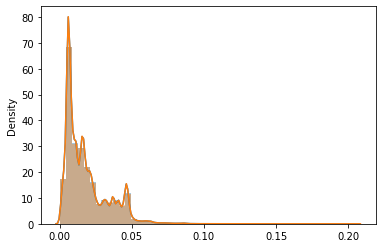

In [18]:
# Seperate test loss calculation
train_mae_loss_1 = np.mean(np.abs(x_train_predict_res_1 - a[:,0]), axis=1)
train_mae_loss_2 = np.mean(np.abs(x_train_predict_res_2 - a[:,1]), axis=1)
sns.distplot(train_mae_loss_1,bins=50,kde=True )
sns.distplot(train_mae_loss_2,bins=50,kde=True )

/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

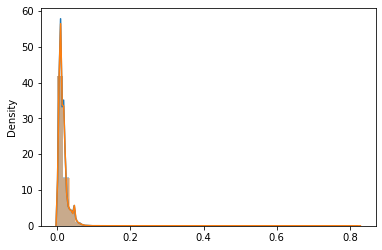

In [19]:
# Seperate test loss calculation
test_mae_loss_1 = np.mean(np.abs(x_test_predict_res_1 - p[:,0]), axis=1)
test_mae_loss_2 = np.mean(np.abs(x_test_predict_res_2 - p[:,1]), axis=1)
sns.distplot(test_mae_loss_1,bins=50,kde=True )
sns.distplot(test_mae_loss_2,bins=50,kde=True )

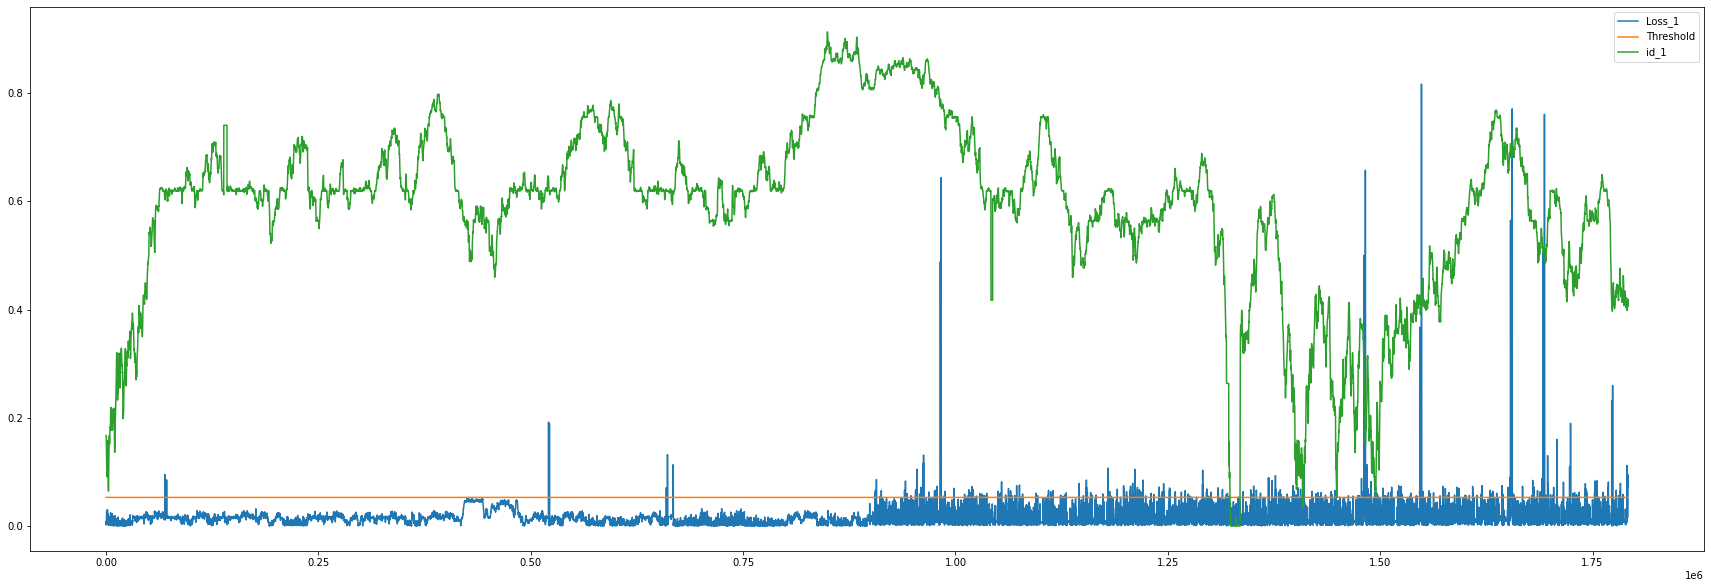

In [82]:
# #plot the threshoold vs the actual loss values
test_score_df = pd.DataFrame(index=df_testID_list[0][TIME_STEP:].index)
test_score_df['id_1'] = df_testID_list[0][TIME_STEP:].Signal1_of_ID
test_score_df['Label'] = df_testID_list[0][TIME_STEP:].Label
test_score_df['loss_1'] = test_mae_loss_1
test_score_df['threshold'] = 0.053
test_score_df['anomaly'] = test_score_df.loss_1 > test_score_df.threshold
test_score_df['notAnomaly'] = test_score_df.loss_1 <= test_score_df.threshold


plt.figure(figsize=(30,10))
plt.plot(test_score_df.index,test_score_df.loss_1, label='Loss_1')
plt.plot(test_score_df.index,test_score_df.threshold, label='Threshold')
plt.plot(test_score_df.index,test_score_df.id_1, label='id_1')
plt.legend()

In [24]:

print(df_testID_list[0][TIME_STEP:].head())

     Label      Time  Signal1_of_ID
215      0  0.000100       0.167412
221      0  0.000103       0.167262
230      0  0.000107       0.167152
236      0  0.000110       0.167022
243      0  0.000113       0.166892


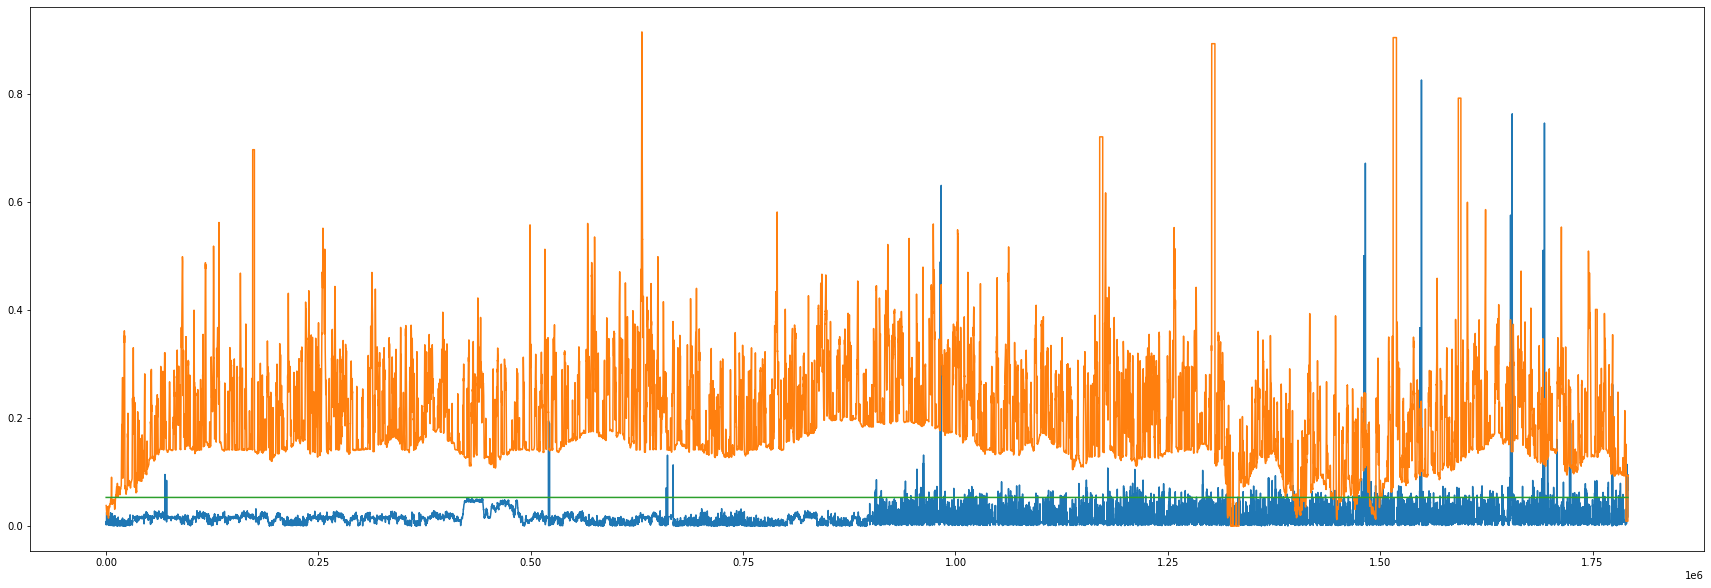

In [83]:
# #plot the threshoold vs the actual loss values
test_score_df_2 = pd.DataFrame(index=df_testID_list[1][TIME_STEP:].index)
test_score_df_2['id_5'] = df_testID_list[1][TIME_STEP:].Signal1_of_ID
test_score_df_2['Label'] = df_testID_list[1][TIME_STEP:].Label
test_score_df_2['loss_2'] = test_mae_loss_2
test_score_df_2['threshold'] = 0.053
test_score_df_2['anomaly'] = test_score_df_2.loss_2 > test_score_df_2.threshold
test_score_df_2['notAnomaly'] = test_score_df_2.loss_2 <= test_score_df_2.threshold


plt.figure(figsize=(30,10))
plt.plot(test_score_df.index,test_score_df_2.loss_2, label=';oss_2')
plt.plot(test_score_df.index,test_score_df_2.id_5, label='id_5')
plt.plot(test_score_df.index,test_score_df_2.threshold, label='Threshold')

In [129]:
anomalies_1 = test_score_df[test_score_df.anomaly == True]
anomalies_2 = test_score_df_2[test_score_df_2.anomaly == True]
notAnomalies_1 = test_score_df[test_score_df.anomaly == False]
notAnomalies_2 = test_score_df_2[test_score_df_2.anomaly == False]

stats = np.empty([2,4],dtype='int')

# For ID_1
TPs_1 = anomalies_1[anomalies_1.Label == anomalies_1.anomaly]

stats[0][0] = (anomalies_1[anomalies_1.Label == anomalies_1.anomaly]).iloc[:,0].shape[0]
FPs_1 = anomalies_1[anomalies_1.Label != anomalies_1.anomaly]

stats[0][1] = (anomalies_1[anomalies_1.Label != anomalies_1.anomaly]).iloc[:,0].shape[0]

FNs_1= notAnomalies_1[notAnomalies_1.Label != notAnomalies_1.anomaly]
stats[0][2] = FNs_1.iloc[:,0].shape[0]

TNs_1= notAnomalies_1[notAnomalies_1.Label == notAnomalies_1.anomaly]
stats[0][3] = TNs_1.iloc[:,0].shape[0]

# For ID_5

TPs_2 = anomalies_2[anomalies_2.Labels Calculation == anomalies_2.anomaly]
stats[1][0] = TPs_2.iloc[:,0].shape[0]

FPs_2 = anomalies_2[anomalies_2.Label != anomalies_2.anomaly]
stats[1][1] = FPs_2.iloc[:,0].shape[0]

FNs_2= notAnomalies_2[notAnomalies_2.Label != notAnomalies_2.anomaly]
stats[1][2] = FNs_2.iloc[:,0].shape[0]

TNs_2= notAnomalies_2[notAnomalies_2.Label == notAnomalies_2.anomaly]
stats[1][3] = TNs_2.iloc[:,0].shape[0]


# FNs_1 = labels_1[labels_1.index != anomalies_1.index]

print(FNs_1.id_1.shape)
print(stats[0,1])
print(stats[0,2])
print(stats[0,3])

(41289,)
3349
41289
204836


/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keywor

<AxesSubplot:ylabel='id_1'>

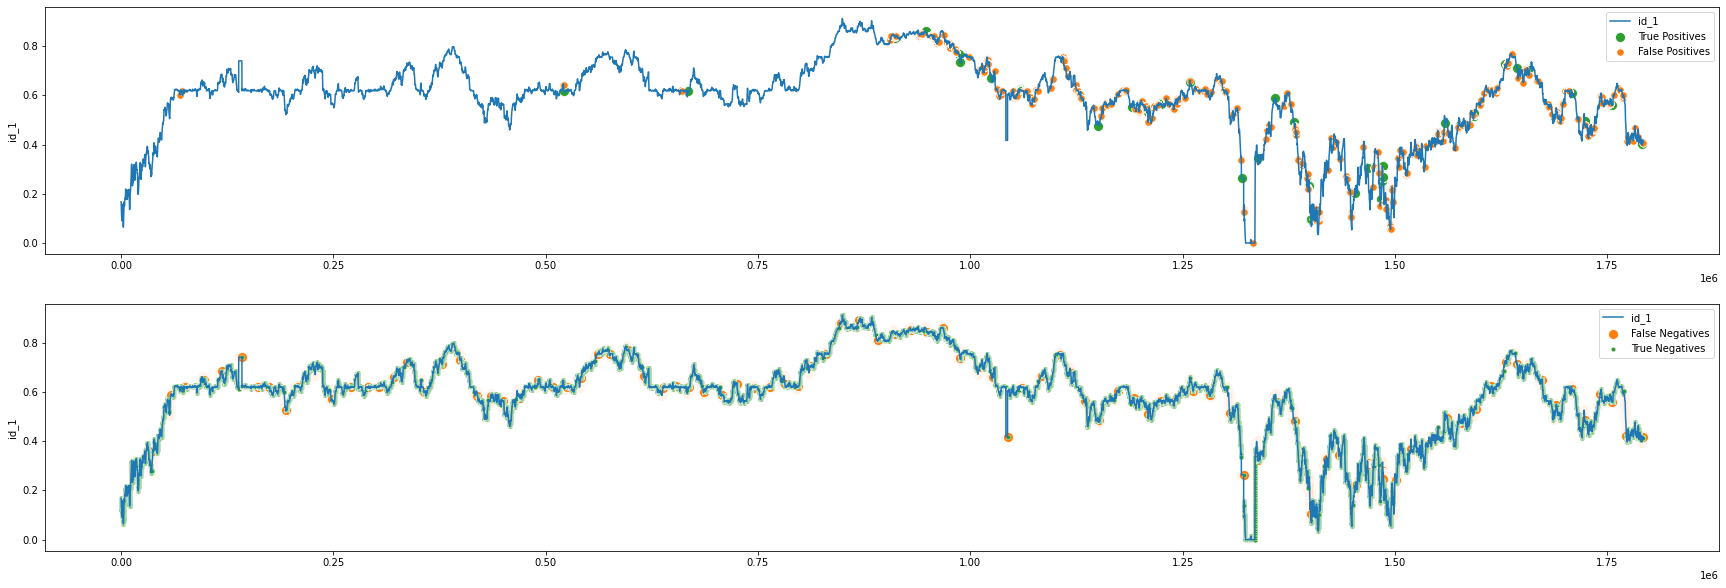

In [134]:
# plt.figure(figsize=(30,10))
fig,axs = plt.subplots(2,1,squeeze=False, figsize=(30,10))
axs[0,0].plot(
test_score_df.index, 
test_score_df.id_1,
label='id_1'
)

sns.scatterplot(
  TPs_1.index, 
  TPs_1.id_1,
  color=sns.color_palette("tab10")[2],
  s=100,
  markers='o',
  label='True Positives',
  ax = axs[0,0]
)

sns.scatterplot(
  FPs_1.index, 
  FPs_1.id_1,
  color=sns.color_palette("tab10")[1],
  s=52,
  label='False Positives',
  ax = axs[0,0]
)
plt.legend()
axs[1,0].plot(
test_score_df.index, 
test_score_df.id_1, 
  label='id_1'
)

sns.scatterplot(
  FNs_1.index, 
  FNs_1.id_1,
  color=sns.color_palette("tab10")[1],
  s=100,
  markers='o',
  label='False Negatives',
  ax = axs[1,0]
)
sns.scatterplot(
  TNs_1.index, 
  TNs_1.id_1,
  color=sns.color_palette("tab10")[2],
  s=20,
  markers='o',
  label='True Negatives',
  ax = axs[1,0]
)



/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keywor

<AxesSubplot:ylabel='id_5'>

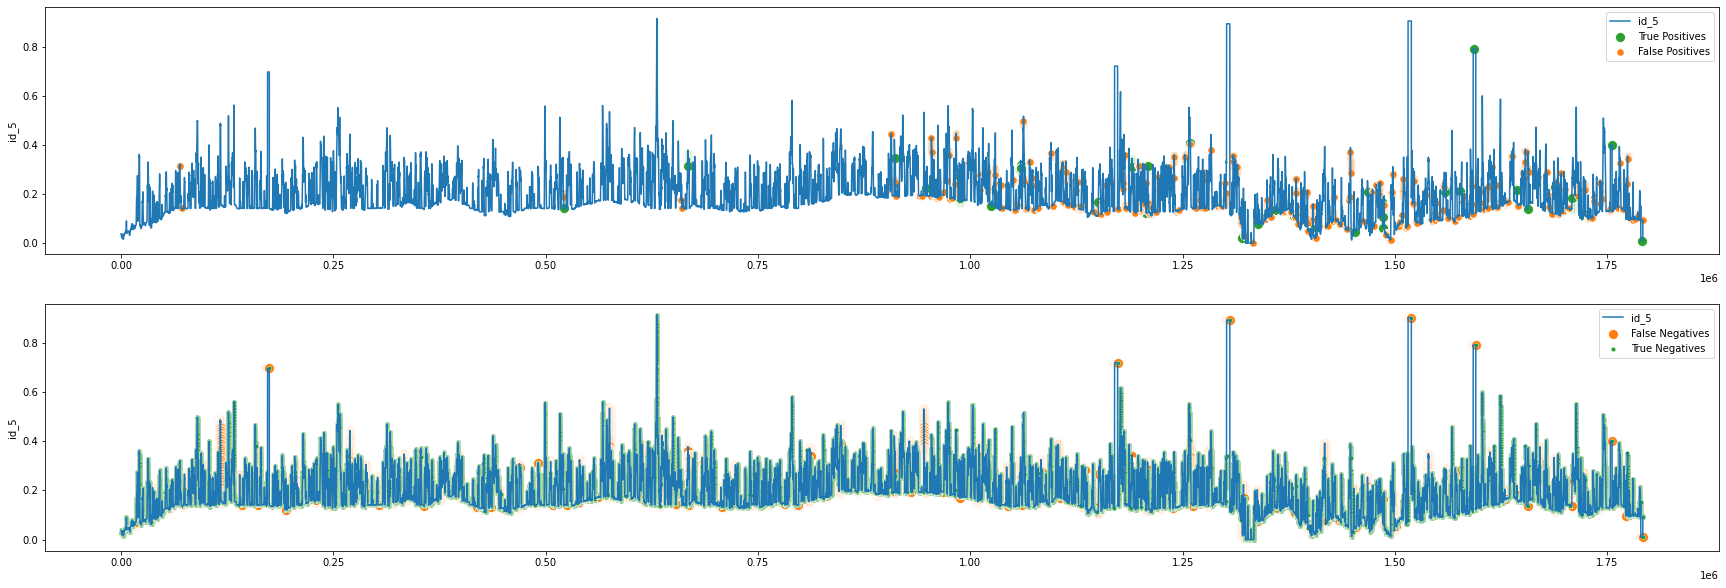

In [136]:
# plt.figure(figsize=(30,10))
fig,axs = plt.subplots(2,1,squeeze=False, figsize=(30,10))
axs[0,0].plot(
test_score_df_2.index, 
test_score_df_2.id_5,
label='id_5'
)

sns.scatterplot(
  TPs_2.index, 
  TPs_2.id_5,
  color=sns.color_palette("tab10")[2],
  s=100,
  markers='o',
  label='True Positives',
  ax = axs[0,0]
)

sns.scatterplot(
  FPs_2.index, 
  FPs_2.id_5,
  color=sns.color_palette("tab10")[1],
  s=52,
  label='False Positives',
  ax = axs[0,0]
)
plt.legend()
axs[1,0].plot(
test_score_df_2.index, 
test_score_df_2.id_5,
  label='id_5'
)

sns.scatterplot(
  FNs_2.index, 
  FNs_2.id_5,
  color=sns.color_palette("tab10")[1],
  s=100,
  markers='o',
  label='False Negatives',
  ax = axs[1,0]
)
sns.scatterplot(
  TNs_2.index, 
  TNs_2.id_5,
  color=sns.color_palette("tab10")[2],
  s=20,
  markers='o',
  label='True Negatives',
  ax = axs[1,0]
)



#### Pie charts of TPs vs FPs for All the IDs

[[   496   3349  41289 204836]
 [   500   3337  41287 204846]]


([<matplotlib.patches.Wedge at 0x7ff300e020f0>,
 [Text(1.199976307338772, 0.0075406780600445495, 'TPs'),
  Text(1.0983663538793602, 0.05992789555591185, 'FPs'),
  Text(0.9798955043938333, 0.6926794355751839, 'FNs'),
  Text(-0.9278009516516158, -0.5909191096202223, 'TNs')])

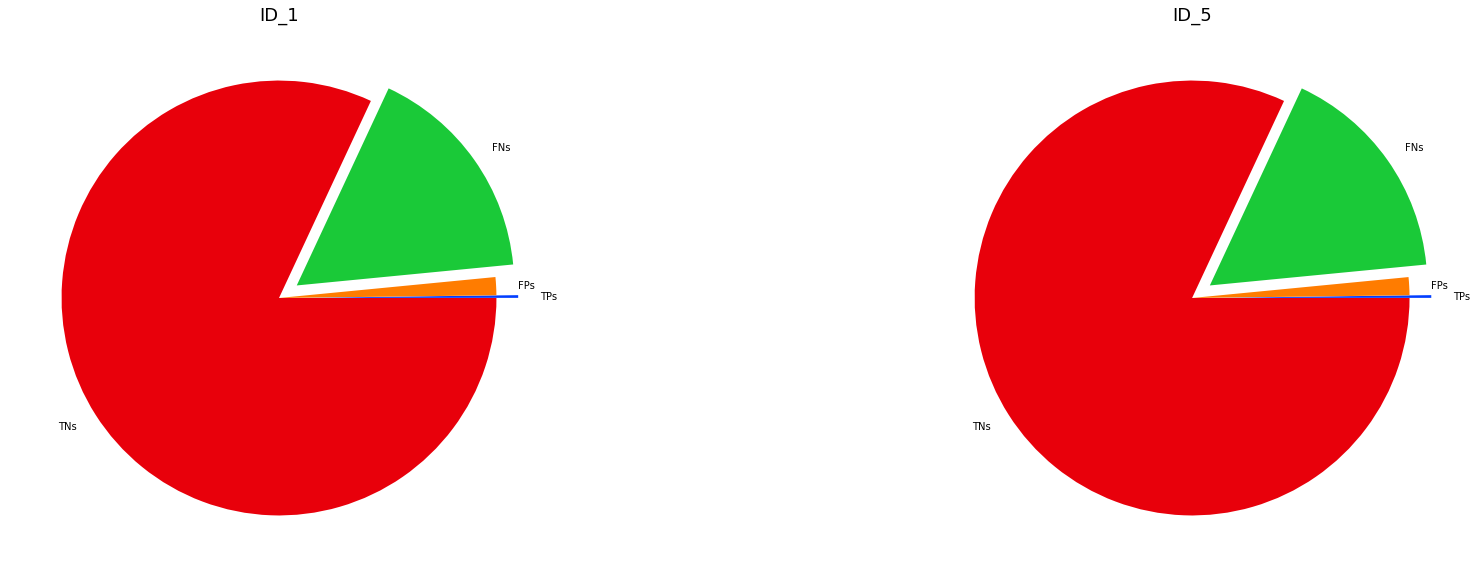

In [137]:
print(stats)

pallete = sns.color_palette('bright')
fig,axs = plt.subplots(1,2,squeeze=False, figsize=(30,10))
fig.set_facecolor('white')
labels = ['TPs', 'FPs', 'FNs', 'TNs']
explode = (0.1, 0, 0.1, 0)

axs[0,0].set_title('ID_1',fontsize=18)
axs[0,0].pie(
stats[0],
labels = labels,
colors = pallete,
explode = explode,
 )

axs[0,1].set_title('ID_5',fontsize=18)

axs[0,1].pie(
stats[1],
labels = labels,
colors = pallete,
explode = explode
)

